В рамках домашнего задания мы предлагаем вам поучаствовать в соревновании [Kaggle](https://www.kaggle.com/t/7e9b43b6978b4c18a58c6b60a2da2ed8). В этом соревновании вы будете прогнозировать цены на автомобили с помощью фрэймворка для AutoML [LightAutoML](https://github.com/sberbank-ai-lab/LightAutoML) by Sberbank AI Lab.


Сначала вы получите базовое решение, а затем сможете посоревноваться между собой и другими участниками на платформе Kaggle.






# Установка необходимых пакетов и загрузка данных

In [1]:
# Google Colab has some problem with install lightautoml
# So, we need to straightforward highlight the last version of packge
!pip install transformers # additional lib for lightautonl (optional)
!pip install lightautoml==0.3.8b1 # lightautoml

# If you work on your own computer, you can use
#!pip install -U lightautoml

# additional
!pip install multiprocessing

!pip install gdown # for data loading
!gdown 1O7n3ztzKWpY6x2vha7uuKBqksE1LjhEn # load training data
!gdown 1gvTvn71-K6mIm_hvBWl9XKKtcqNuoRhp # load test data
!gdown 1LyayILm9dUzifg55h3w1eAHkizGMOgxZ # load sample submission

from IPython.display import clear_output
clear_output()

# Импортирование необходимых библиотек

In [2]:
import multiprocessing as mp
import pandas as pd

from sklearn.metrics import mean_absolute_error
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

# Загрузка данных

Данные соревнования представляют собой таблицы с некоторым набором характеристик машин и целевой переменной - цена продажи.

Описание признаков:
* row_id - ID машины
* vehicle_manufacturer - производитель машины
* vehicle_model - модель машины
* vehicle_category - тип кузова
* current_mileage - текущий пробег
* vehicle_year - год выпуска
* vehicle_gearbox_type - тип коробки передач
* doors_cnt - кол-во дверей
* wheels - тип машины (праворульная/леворульная)
* vehicle_color - цвет машины
* vehicle_interior_color - цвет салона
* car_vin - идентификационный номер машины
* car_leather_interior - идентификатор, кожаный ли салон
* deal_type - машина продается или арендуется

**Целевая переменная** - final_price

Загрузим обучающую и тестовую выборки и посмотрим на них.

In [3]:
train_data = pd.read_csv('./train_data.csv')
train_data.head()

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price
0,0,TOYOTA,Aqua s,Sedan,133000,2014,Automatic,4/5,Right-hand drive,Silver,Black,NaN,0,For Sale,3650.0
1,1,MERCEDES-BENZ,C 220,Sedan,24500,2010,Manual,4/5,Left wheel,Silver,Black,NaN,0,For Sale,6800.0
2,2,HYUNDAI,Veloster,Hatchback,31000,2016,Tiptronic,2/3,Left wheel,Silver,Black,KMHTC6AE3GU293912,1,For Sale,6300.0
3,3,HYUNDAI,Santa FE,Jeep,115459,2015,Automatic,4/5,Left wheel,Blue,Black,NaN,1,For Sale,14488.0
4,4,TOYOTA,CHR,Jeep,18950,2019,Automatic,4/5,Left wheel,Black,NaN,JTNKHMBX7K1030253,1,For Sale,5000.0


In [4]:
test_data = pd.read_csv('./test_data.csv')
test_data.head()

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type
0,35000,TOYOTA,Prius,Hatchback,323733,2012,Automatic,4/5,Left wheel,Grey,Black,JTDKN3DU6C5439638,1,For Sale
1,35001,HYUNDAI,Elantra,Sedan,112000,2013,Tiptronic,4/5,Left wheel,Grey,Black,SURATSHIA,1,For Sale
2,35002,LEXUS,NX 300,Jeep,16920,2018,Automatic,NaN,Left wheel,Brown,NaN,JTJYARBZ5J2104521,1,For Sale
3,35003,LEXUS,CT 200h,Hatchback,302742,2012,Automatic,4/5,Left wheel,White,NaN,JTHKD5BH4C2070945,1,For Sale
4,35004,TOYOTA,RAV 4,Jeep,1800,2002,Manual,4/5,Left wheel,Silver,Black,NaN,0,For Sale


# Подготовка AutoML пресета

В первую очередь необходимо "описать" задачу ```Task``` для AutoML.
1. Настроить тип задачи (```name```), которую мы будем решать:
* 'reg' для задачи регрессии <- наша текущая задача

  Также в LightAutoML доступны следующие типы:
  * 'binary' для бинарной классификации
  * 'multiclass' для многоклассовой классификации
  * 'multi:reg' для множественной регрессии
  * 'multilabel' для многометочной классификации (предсказываем несколько меток)

2. Выбрать одну или несколько функций оптимизации ```loss``` и целевых метрик ```metric```. Для задачи регрессии лосс-функции и метрики одинаковые и могут быть следующими:
* 'mse' - Mean Squared Error
* 'mae' - Mean Absolute Error
* 'mape' - Mean Absolute Percentage Error
* 'rmsle' - Root Mean Squared Log Error
* 'huber' - Huber loss (с параметром a - порог)
* 'fair' - Fair loss (с параметром c - smoothness)
* 'quantile' - Quantile loss (с параметром q - квантиль)

В предложенном соревновании целевая метрика - MAE, поэтому мы укажем её в качестве целевой функции и метрики.


In [5]:
task = Task(name='reg', loss='mae', metric='mae')

Далее мы должны настроить словарь ролей (```roles```) столбцов. Ключом в словаре должно быть имя роли, а значением должен быть список названий соответствующих столбцов.  

Единственное, что вы **обязаны** указать - это целевую переменную 'target'. Остальные роли настраиваются опционально в зависимости от задачи. Пример возможных значений:

* 'numeric' - список числовых признаков
* 'category' - список категориальных признаков
* 'text' - признаки с текстовыми данными
* 'datetime' - признаки в формате дата-время
* 'date' - признаки в формате дата (только дата, без времени)
* 'group' - признаки, по которым данные могут быть разделены на группы (используется для GroupKFold, см. [справку](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html))
* 'drop' - список признаков для удаления
* 'weights' - веса признаков для целевой функции и/или метрик

и др.


*Замечание:* LightAutoML может автоматически определять типы и роли столбцов данных. Однако, иногда полезно указать роль в явном виде.

Для начала укажем целевую переменную ```'final_price'``` и потребуем не учитывать колонку ```'row_ID'```.

In [6]:
roles = {'target': 'final_price',
         'drop': ['row_ID']
         }

# Запуск AutoML

В целом, весь пайплайн для AutoML может быть кастомизирован под конкретные задачи и идеи пользователя (подробнее об этом см. [тут](https://github.com/sb-ai-lab/LightAutoML/blob/master/examples/tutorials/Tutorial_6_custom_pipeline.ipynb)), но мы начнём с, так называемых, пресетов, готовых наборов решений. В частности, мы будем использовать ```TabularAutoML``` пресет для работы с табличными данными, алгоритм которого представлен на картинке.

![TabularAutoML preset pipeline](https://github.com/sberbank-ai-lab/LightAutoML/raw/master/imgs/tutorial_2_pipeline.png)

Также в библиотеке LightAutoML имеются ```TabularCVAutoML``` - пресет для работы с картинками и ```TabularNLPAutoML``` - пресет для работы с текстами.

Основное преимущество TabularAutoML пресета в том, что он быстро обеспечивает пользователя достаточно хорошей моделью, сосредотачиваясь на популярных и общепризнано сильных подходах: линейная модель с L2 регуляризацией и два градиентных бустинга LightGBM и CatBoost.

*Замечание:* Обратите внимание на порядок, в котором рассматриваются данные модели: с его помощью AutoML управляет временем обучения.  Если задано ограниченные (но разумные) временные рамки, то по крайней мере, самая быстрая модель будет обучена. С другой стороны, если времени достаточно много, быстрая обработка первых моделей позволяет нам выделить больше времени на оптимизацию более сложных, но медленных подходов.


Задаем параметры для TabularAutoML:
1. Самый главный параметр - это ```task```, тип задачи, который мы решаем, его мы определили ранее.
2. Ограничим количество проверяемых алгоритмов ```general_params``` только двумя: линейной моделью и LightGBM. Важное замечание, что значение данного параметра - это лист листов.
3. Также рекомендуется ограничить доступные AutoML вычислительные ресурсы, параметр ```cpu_limit```, чтобы не заполнить все возможные.
4. Параметр ```timeout``` определяет ограничение по времени в секундах для обучения модели.
5. В ```reader_params``` задается словарь параметров для препроцессинга данных (кол-во разбиений для валидации, random_state и др.)

In [7]:
# несколько важных переменных
N_THREADS = mp.cpu_count()
N_FOLDS = 5
RANDOM_STATE = 42
TIMEOUT = 3600

automl = TabularAutoML(task = task,
                       general_params = {'use_algos': [['linear_l2', 'lgb']]},
                       cpu_limit = N_THREADS,
                       timeout = TIMEOUT,
                       reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                       )

Обучения AutoML модели запускается методом ```fit_predict()```. Основные его параметры:
* train_data - тренировачный датасет
* roles - словарь с ролями
* verbose - контролирует кол-во сообщений от AutoML (от 0 до 4, где 4 - процесс каждого алгоритма логгируется).

Обратите внимание, что вызов метода ```fit_predict()``` вернёт **out-of-fold** предсказания для обучающей выборки.  

In [8]:
pred = automl.fit_predict(train_data, roles = roles, verbose = 1)

[06:09:26] Stdout logging level is INFO.


INFO:lightautoml.automl.presets.base:Stdout logging level is INFO.


[06:09:26] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer


[06:09:26] Task: reg



INFO:lightautoml.automl.presets.base:Task: reg



[06:09:26] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[06:09:26] - time: 3600.00 seconds


INFO:lightautoml.automl.presets.base:- time: 3600.00 seconds


[06:09:26] - CPU: 2 cores


INFO:lightautoml.automl.presets.base:- CPU: 2 cores


[06:09:26] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[06:09:26] Train data shape: (35000, 15)



INFO:lightautoml.reader.base:Train data shape: (35000, 15)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []


[06:09:35] Layer 1 train process start. Time left 3591.03 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 3591.03 secs


[06:09:38] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [21, 22, 23, 24, 25, 26, 27], 'embed_sizes': array([12,  5,  3, 18,  5,  3,  3], dtype=int32), 'data_size': 28}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = -4663.107697335379
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = -4661.304810651507
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = -4658.975259974888
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = -4640.7796734444755
INFO3:lightautoml.ml_algo.torch_based.linear_mod

[06:10:00] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -3388.223888290623


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -3388.223888290623


[06:10:00] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[06:10:00] Time left 3566.79 secs



INFO:lightautoml.automl.base:Time left 3566.79 secs

INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's l1: 3073.37
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's l1: 2923.24
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's l1: 2887.02
DEBUG:lightautoml.ml_algo.boost_lgbm:[400]	valid's l1: 2859.61
DEBUG:lightautoml.ml_algo.boost_lgbm:[500]	valid's l1: 2840.87
DEBUG:lightautoml.ml_algo.boost_lgbm:[600]	valid's l1: 2824.8
DEBUG:lightautoml.ml_algo.boost_lgbm:[700]	valid's l1: 2814.9
DEBUG:lightautoml.ml_algo.boost_lgbm:[800]	valid's l1: 2807.23
DEBUG:lightautoml.ml_algo.boost_lgbm:[900]	valid's l1: 2801.61
DEBUG:lightautoml.ml_algo.boost_lgbm:[1000]	valid's l1: 2795.28
DEBUG:lightautoml.ml_algo.boost_lgbm:[1100]	valid's l1: 2791.52
DEBUG:lightautoml.ml_algo.boost_lgbm:[1200]	valid's l1: 2785.17
DEBUG:lightautoml.ml_algo.boost_lgbm:Did not meet early stopping. Best iteration is:
[1190]

[06:10:07] Selector_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Selector_LightGBM fitting and predicting completed


[06:10:08] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.03, 'num_leaves': 32, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 0.5, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 1200, 'early_stopping_rounds': 200, 'random_state': 42}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's l1: 2863.4
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's l1: 2774.16
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's l1: 2747.66
DEBUG:lightautoml.ml_algo.boost_lgbm:[400]	valid's l1: 2738.97
DEBUG:lightautoml.ml_algo.boost_lgbm:[500]	valid's l

[06:10:39] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -2596.044819063762


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -2596.044819063762


[06:10:39] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


[06:10:39] Time left 3527.61 secs



INFO:lightautoml.automl.base:Time left 3527.61 secs



[06:10:39] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[06:10:39] Blending: optimization starts with equal weights and score -2891.8005093227657


INFO:lightautoml.automl.blend:Blending: optimization starts with equal weights and score -2891.8005093227657


[06:10:39] Blending: iteration 0: score = -2596.044819063762, weights = [0. 1.]


INFO:lightautoml.automl.blend:Blending: iteration 0: score = -2596.044819063762, weights = [0. 1.]


[06:10:39] Blending: iteration 1: score = -2596.044819063762, weights = [0. 1.]


INFO:lightautoml.automl.blend:Blending: iteration 1: score = -2596.044819063762, weights = [0. 1.]


[06:10:39] Blending: no score update. Terminated



INFO:lightautoml.automl.blend:Blending: no score update. Terminated



[06:10:39] Automl preset training completed in 72.44 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 72.44 seconds



[06:10:39] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) 



# Получение предсказаний

Посмотрим, какое качество получилось на обучающей выборке, и получим предсказания для тестовой.

Обратите внимание, что переменная ```pred```, полученная на предыдущем шаге, - это **НЕ** привычный пользователям sklearn-а массив с предсказаниями. Для получения массива с предсказаниями, необходимо обратиться к полю ```data``` переменной ```pred```.

In [9]:
print('OOF score: {}'.format(mean_absolute_error(train_data['final_price'].values, pred.data[:, 0])))

OOF score: 2596.044819063762


In [10]:
test_pred = automl.predict(test_data)

# Подготовка решения для Kaggle

Загрузим шаблон и запишем в него предсказания.

In [11]:
submission = pd.read_csv('./sample_submission.csv')
submission['final_price'] = test_pred.data[:, 0]
submission.head()

,row_ID,final_price
0,35000,2890.398682
1,35001,6084.673828
2,35002,2443.868408
3,35003,441.074036
4,35004,3858.434326


In [12]:
submission.to_csv('lightautoml_sample_submission.csv', index = False)

Полученное решение можно загрузить на соревнование [Kaggle](https://www.kaggle.com/t/7e9b43b6978b4c18a58c6b60a2da2ed8).


**В качестве домашнего задания мы предлагаем вам самостоятельно поэксперементировать с LightAutoML, попробовать побить текущее решение и посоревноваться между собой.**

# Что можно ещё попробовать?

* Как бы ни был хорош AutoML, data scientist обладает несомненным преимуществом в виде своего опыта:) Например, вы можете придумать сложные признаки и/или ручной препроцессинг данных перед тем, как запускать LightAutoML. Какие идеи могут быть полезны:  
  * убрать редкие значения (outliers);
  * посчитать различные аггрегированные значения, например, средние значения числовых признаков по разным группам или частоту возникновения категорий;   
  * поработать с VIN номером машины (см. [VIN](https://ru.wikipedia.org/wiki/%D0%98%D0%B4%D0%B5%D0%BD%D1%82%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%BD%D1%8B%D0%B9_%D0%BD%D0%BE%D0%BC%D0%B5%D1%80_%D1%82%D1%80%D0%B0%D0%BD%D1%81%D0%BF%D0%BE%D1%80%D1%82%D0%BD%D0%BE%D0%B3%D0%BE_%D1%81%D1%80%D0%B5%D0%B4%D1%81%D1%82%D0%B2%D0%B0))  
  * выделить "особые фишки" машины (например, необычный цвет);
  * выделить дополнительные группы в данных, например, объединить производителей по странам и/или модели по "премиальности" итд.

* Рассмотреть другой набор моделей.
* Попробовать мягче ограничивать перебор решений (увеличить TIMEOUT и/или поменять TabularAutoML на TabularUtilizedAutoML).
* "Поиграться" с ролями.
* Настроить пайплайн [полностью самим](https://github.com/sb-ai-lab/LightAutoML/blob/master/examples/tutorials/Tutorial_6_custom_pipeline.ipynb)) - высший пилотаж :)


# Баллы за эксперименты распределяются следующим образом:
* Реализована какая-нибудь генерация признаков, которая хоть как-то улучшает базовое решение - 5 баллов;
* За особо креативные подходы в генерации признаков - до 10 баллов дополнительно;
* Подобраны гиперпараметры TabularAutoML - до 5 баллов;
* Отдельно оцениваются эксперименты с TIMEOUT (в т.ч. мотивированный переход на TabularUtilizedAutoML) - 3 балла;
------

Особые бонусы:

* Реализован кастомный pipeline AutoML - до 10 баллов;
* Топ K (K $\in$ {1, 2, 3}) на Kaggle - (4 - K) * 5 баллов.


![Good Luck!](https://images.fineartamerica.com/images/artworkimages/mediumlarge/2/no-prob-lama-magdalena-walulik.jpg)


#EDA and Feature tuning

In [13]:
train_data.sample(5)

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price
5472,5472,HYUNDAI,H1,Minivan,68578,2014,Automatic,4/5,Left wheel,Silver,Black,NaN,1,For Sale,7831.0
22924,22924,LEXUS,RX 450,Jeep,59858,2016,Automatic,4/5,Left wheel,Silver,NaN,2T2ZZMCA3GC021395,1,For Sale,3800.0
9241,9241,HYUNDAI,Accent,Sedan,4444,1997,Manual,2/3,Left wheel,Blue,Black,NaN,0,For Sale,319.0
22340,22340,HYUNDAI,Tucson,Jeep,116082,2016,Automatic,4/5,Left wheel,White,Black,NaN,1,For Sale,12122.0
16765,16765,HYUNDAI,Tucson,Jeep,108675,2013,Automatic,4/5,Left wheel,Black,NaN,KM8JU3AC8DU772422,1,For Sale,225.0


In [14]:
train_data['car_vds'] = train_data['car_vin'].apply(lambda x: str(x).replace(" ", "")[3:8])
test_data['car_vds'] = test_data['car_vin'].apply(lambda x: str(x).replace(" ", "")[3:8])

train_data['country'] = train_data['car_vin'].apply(lambda x: str(x).replace(" ", "")[0:3])
test_data['country'] = test_data['car_vin'].apply(lambda x: str(x).replace(" ", "")[0:3])

In [15]:
train_data.isna().sum() / train_data.shape[0]

row_ID                    0.000000
vehicle_manufacturer      0.000029
vehicle_model             0.000200
vehicle_category          0.000029
current_mileage           0.000000
vehicle_year              0.000000
vehicle_gearbox_type      0.000029
doors_cnt                 0.021286
wheels                    0.000029
vehicle_color             0.011457
vehicle_interior_color    0.191943
car_vin                   0.671771
car_leather_interior      0.000000
deal_type                 0.000000
final_price               0.000000
car_vds                   0.000000
country                   0.000000
dtype: float64

In [16]:
test_data.isna().sum() / train_data.shape[0]

row_ID                    0.000000
vehicle_manufacturer      0.000029
vehicle_model             0.000057
vehicle_category          0.000029
current_mileage           0.000000
vehicle_year              0.000000
vehicle_gearbox_type      0.000029
doors_cnt                 0.006371
wheels                    0.000029
vehicle_color             0.003829
vehicle_interior_color    0.059371
car_vin                   0.203743
car_leather_interior      0.000000
deal_type                 0.000000
car_vds                   0.000000
country                   0.000000
dtype: float64

In [17]:
train_data['vehicle_manufacturer'].value_counts(normalize=True)

TOYOTA           0.193377
HYUNDAI          0.179605
MERCEDES-BENZ    0.114918
FORD             0.064830
LEXUS            0.050744
                   ...   
MG               0.000029
JAC              0.000029
TATA             0.000029
LANCIA           0.000029
LAMBORGHINI      0.000029
Name: vehicle_manufacturer, Length: 68, dtype: float64

In [18]:
num_cols = train_data.select_dtypes(exclude = 'object')
cat_cols = train_data.select_dtypes(include = 'object')

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
%matplotlib inline

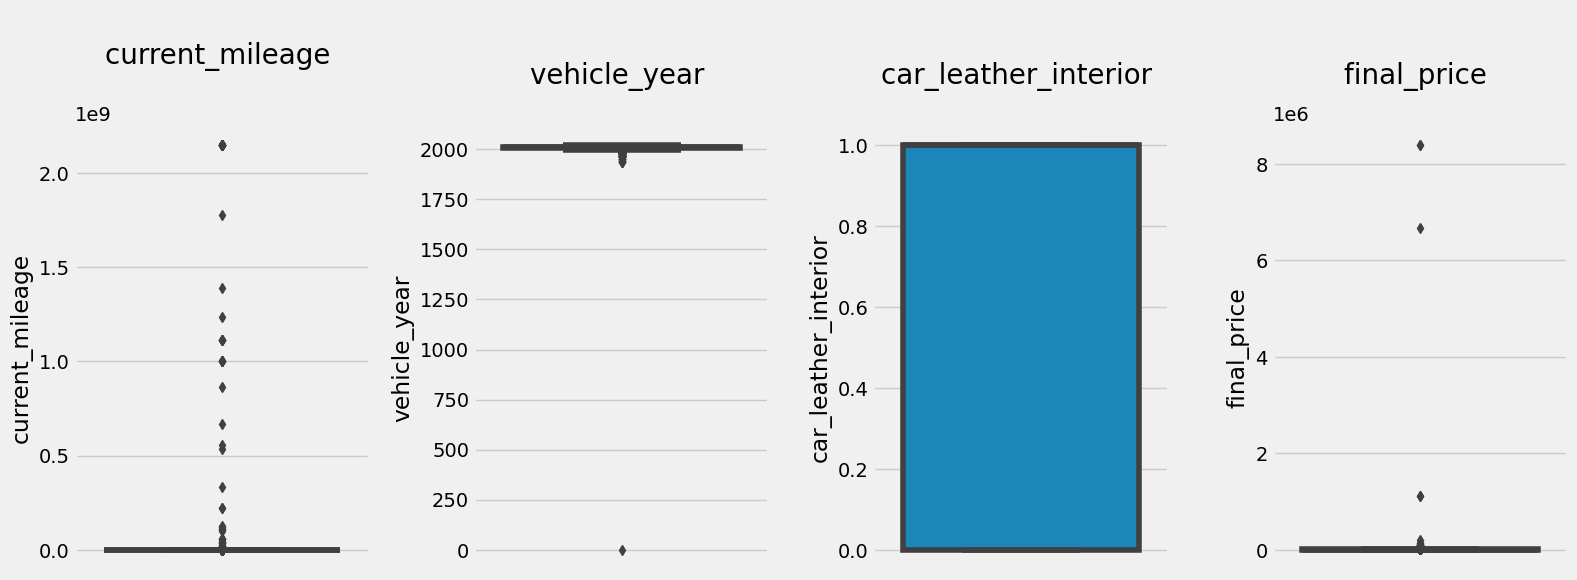

In [20]:
cols = num_cols.columns

plt.figure(figsize = (16, 20))
plotnumber = 1

for i in range(1, len(cols)):
    if plotnumber <= 16:
        ax = plt.subplot(4, 4, plotnumber)
        sns.boxplot(y = cols[i], data = train_data, ax = ax)
        plt.title(f"\n{cols[i]} \n", fontsize = 20)

    plotnumber += 1

plt.tight_layout()
plt.show()

In [21]:
num_cols_test = test_data.select_dtypes(exclude = 'object')
cat_cols_test = test_data.select_dtypes(include = 'object')

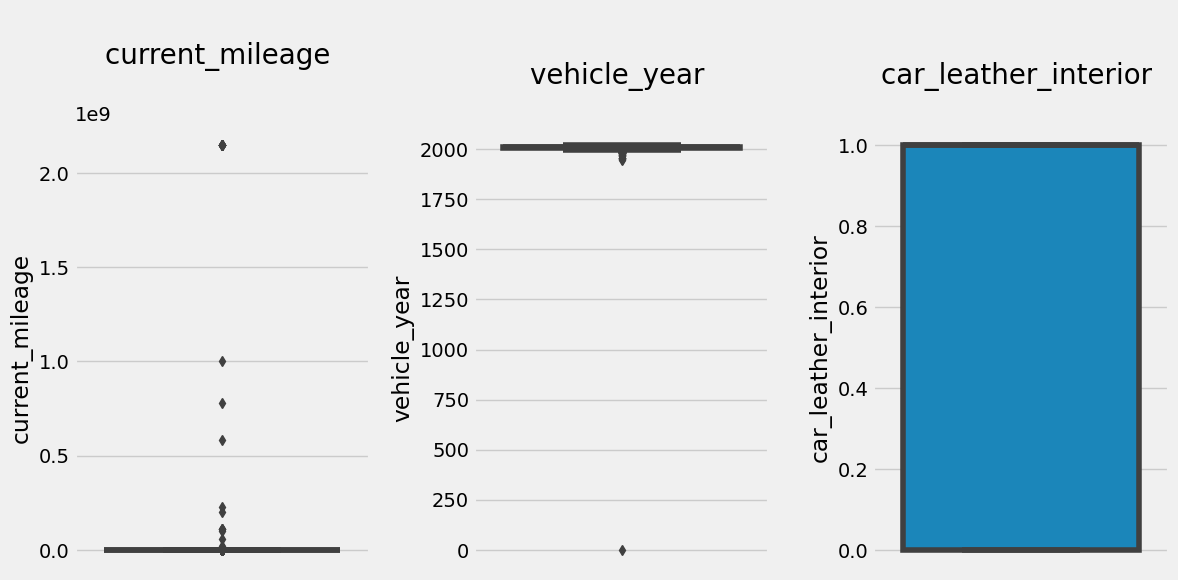

In [22]:
cols = num_cols_test.columns

plt.figure(figsize = (16, 20))
plotnumber = 1

for i in range(1, len(cols)):
    if plotnumber <= 16:
        ax = plt.subplot(4, 4, plotnumber)
        sns.boxplot(y = cols[i], data = test_data, ax = ax)
        plt.title(f"\n{cols[i]} \n", fontsize = 20)

    plotnumber += 1

plt.tight_layout()
plt.show()

In [23]:
train_data = train_data[train_data['final_price']< 1000000]

In [24]:
train_data.deal_type.value_counts()

For Sale    34367
For Rent      628
Name: deal_type, dtype: int64

In [25]:
train_data['car_cond'] = train_data['current_mileage'] / (2023 - train_data['vehicle_year'])

<Axes: xlabel='current_mileage', ylabel='final_price'>

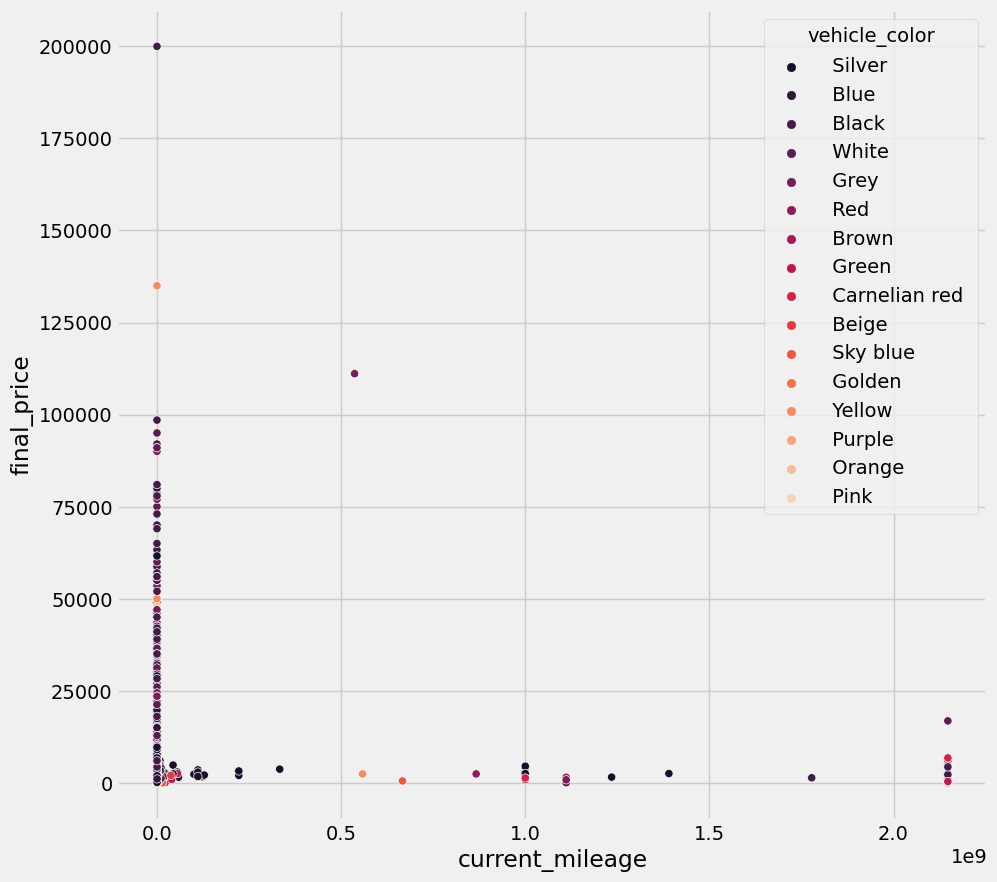

In [26]:
plt.subplots(figsize=(10,10))
sns.scatterplot(x = 'current_mileage', y = 'final_price', data = train_data, hue='vehicle_color', palette='rocket')


<Axes: xlabel='current_mileage', ylabel='final_price'>

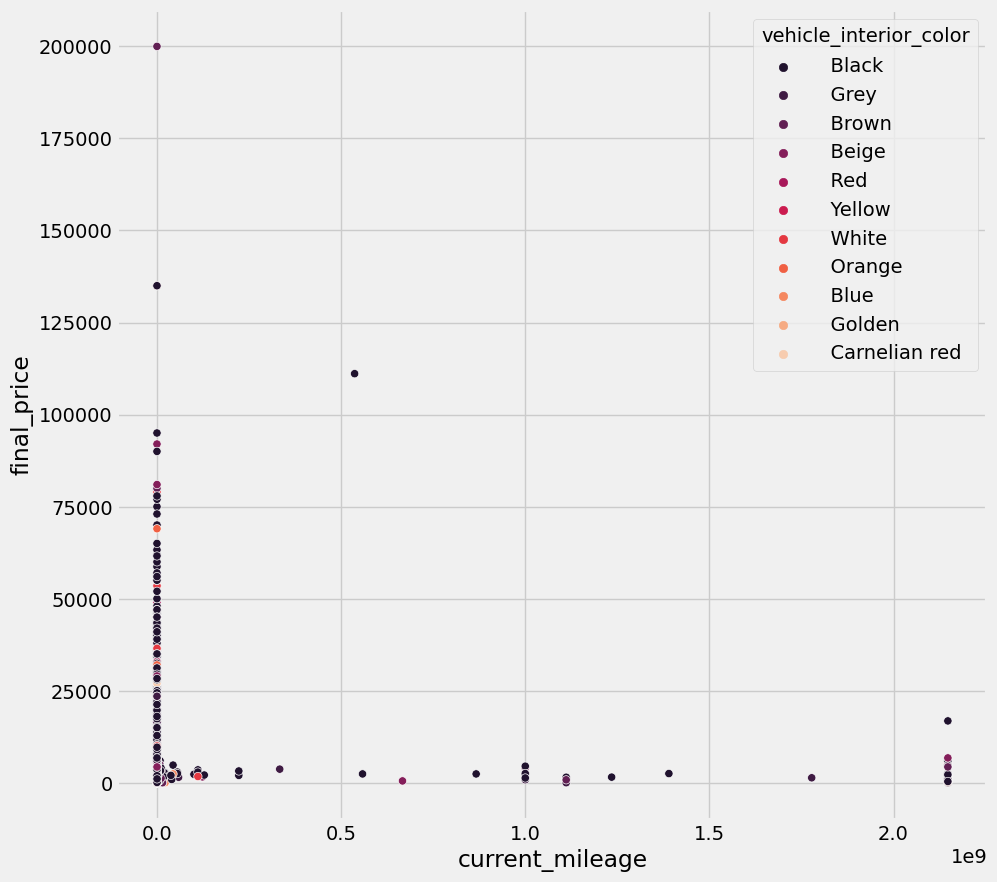

In [27]:
plt.subplots(figsize=(10,10))
sns.scatterplot(x = 'current_mileage', y = 'final_price', data = train_data, hue='vehicle_interior_color', palette='rocket')

In [28]:
def spec_col_int(col: str):

  if col in ['Golden', 'Carnelian red', 'Yellow', 'Blue', 'White', 'Red', 'Beige']:
    return 1
  else:
    return 0

def spec_col_out(col: str):

  if col in ['Golden', 'Carnelian red', 'Yellow', 'Pink', 'Red', 'Purple', 'Beige']:
    return 1
  else:
    return 0

In [29]:
train_data['spec_col_int'] = train_data['vehicle_interior_color'].fillna(0).apply(lambda x: spec_col_int(str(x).replace(" ", "")))
train_data['spec_col_out'] = train_data['vehicle_color'].fillna(0).apply(lambda x: spec_col_out(str(x).replace(" ", "")))

<Axes: ylabel='final_price'>

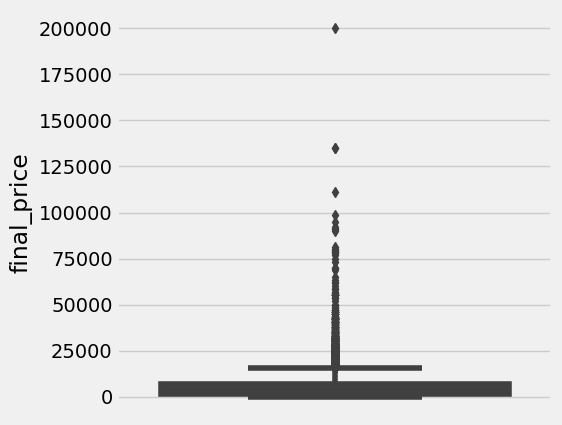

In [32]:
f, ax = plt.subplots(figsize = (5,5))

sns.boxplot(y = 'final_price', data = train_data, ax = ax)


In [33]:
test_data['spec_col_int'] = test_data['vehicle_interior_color'].fillna(0).apply(lambda x: spec_col_int(str(x).replace(" ", "")))
test_data['spec_col_out'] = test_data['vehicle_color'].fillna(0).apply(lambda x: spec_col_out(str(x).replace(" ", "")))

In [34]:
test_data['car_cond'] = test_data['current_mileage'] / (2023 - test_data['vehicle_year'])

In [35]:
cols_drop = ['deal_type']

In [36]:
train_data.drop(columns=cols_drop, inplace=True)
test_data.drop(columns=cols_drop, inplace=True)

In [58]:
train_data.set_index('row_ID', inplace=True)

In [59]:
test_data.set_index('row_ID', inplace=True)

#Custom LAMA

In [45]:
from lightautoml.ml_algo.linear_sklearn import LinearL1CD, LinearEstimator, LinearLBFGS

In [39]:
# Imports from our package
from lightautoml.automl.base import AutoML
from lightautoml.ml_algo.boost_lgbm import BoostLGBM
from lightautoml.ml_algo.tuning.optuna import OptunaTuner
from lightautoml.pipelines.features.lgb_pipeline import LGBSimpleFeatures
from lightautoml.pipelines.ml.base import MLPipeline
from lightautoml.pipelines.selection.importance_based import ImportanceCutoffSelector, ModelBasedImportanceEstimator
from lightautoml.reader.base import PandasToPandasReader
from lightautoml.tasks import Task
from lightautoml.automl.blend import WeightedBlender

In [111]:
# несколько важных переменных
N_THREADS = mp.cpu_count()
N_FOLDS = 5
RANDOM_STATE = 42
TIMEOUT = 3600


In [112]:
task = Task(name='reg', loss='mae', metric='mae')
reader = PandasToPandasReader(task, cv=N_FOLDS, random_state=RANDOM_STATE)


In [113]:
model0 = BoostLGBM(
    default_params={'learning_rate': 0.05, 'num_leaves': 64, 'seed': 42, 'num_threads': N_THREADS}
)
pipe0 = LGBSimpleFeatures()
mbie = ModelBasedImportanceEstimator()
selector = ImportanceCutoffSelector(pipe0, model0, mbie, cutoff=0)

In [114]:


pipe = LGBSimpleFeatures()

params_tuner1 = OptunaTuner(n_trials=20, timeout=30) # stop after 20 iterations or after 30 seconds
model1 = LinearLBFGS(
    default_params={'early_stopping': 5, 'cs':[0.01, 0.1, 0.5]},
    freeze_defaults=True
)
model2 = BoostLGBM(
    default_params={'learning_rate': 0.05, 'num_leaves': 128, 'seed': 1, 'num_threads': N_THREADS}
)
model3 = BoostLGBM(
    default_params={'learning_rate': 0.025, 'num_leaves': 64, 'seed': 2, 'num_threads': N_THREADS}
)

pipeline_lvl1 = MLPipeline([
    (model1, params_tuner1),
    model2,
    model3
], pre_selection=selector, features_pipeline=pipe, post_selection=None)

In [115]:
pipe1 = LGBSimpleFeatures()

model = LinearLBFGS(
    default_params={'early_stopping': 5, 'cs':[0.01, 0.1, 0.5]},
    freeze_defaults=True
)

pipeline_lvl2 = MLPipeline([model], pre_selection=None, features_pipeline=pipe1, post_selection=None)

In [116]:
print(LinearLBFGS.__doc__)

LBFGS L2 regression based on torch.

    default_params:

        - cs: List of regularization coefficients.
        - max_iter: Maximum iterations of L-BFGS.
        - tol: The tolerance for the stopping criteria.
        - early_stopping: Maximum rounds without improving.

    freeze_defaults:

        - ``True`` :  params may be rewrited depending on dataset.
        - ``False``:  params may be changed only manually or with tuning.

    timer: :class:`~lightautoml.utils.timer.Timer` instance or ``None``.

    


In [117]:
%%time

automl = AutoML(reader, [
    [pipeline_lvl1],
    [pipeline_lvl2],
], skip_conn=False)

CPU times: user 67 µs, sys: 1 µs, total: 68 µs
Wall time: 74.1 µs


In [118]:
train_data.sample()

,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,final_price,car_vds,country,car_cond,spec_col_int,spec_col_out
row_ID,,,,,,,,,,,,,,,,,,
21465,HYUNDAI,H1,Minivan,68578,2014,Automatic,4/5,Left wheel,Silver,Black,NaN,1,7831.0,,nan,7619.777778,0,0


In [119]:
cat_cols_list = list(cat_cols.columns)
cat_cols_list.remove('deal_type')
cat_cols_list.remove('car_vin')


cat_cols_list

['vehicle_manufacturer',
 'vehicle_model',
 'vehicle_category',
 'vehicle_gearbox_type',
 'doors_cnt',
 'wheels',
 'vehicle_color',
 'vehicle_interior_color',
 'car_vds',
 'country']

In [120]:

num_cols_list = list(num_cols.columns)
num_cols_list.remove('row_ID')
num_cols_list.remove('final_price')
num_cols_list += ['spec_col_int']
num_cols_list += ['spec_col_out']
num_cols_list += ['car_cond']

num_cols_list

['current_mileage',
 'vehicle_year',
 'car_leather_interior',
 'spec_col_int',
 'spec_col_out',
 'car_cond']

In [121]:
%%time

oof_pred = automl.fit_predict(train_data, roles={'target': 'final_price', 'category': cat_cols_list, 'numeric': num_cols_list})
print('oof_pred:\n{}\nShape = {}'.format(oof_pred, oof_pred.shape))

INFO:lightautoml.reader.base:Train data shape: (34995, 18)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []
INFO:lightautoml.automl.base:Layer 1 train process start. Time left 9999999988.04 secs
INFO3:lightautoml.ml_algo.boost_lgbm:[LightGBM] [Warning] seed is set=42, random_state=42 will be ignored. Current value: seed=42
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's l1: 1933.68
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's l1: 1856.29
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's l1: 1815.51
DEBUG:lightautoml.ml_algo.boost_lgbm:[400]	valid's l1: 1795.34
DEBUG:lightautoml.ml_algo.boost_lgbm:[500]	valid's l1: 1779.61
DEBUG:lightautoml.ml_algo.boost_lgbm:[600]	valid's l1: 1767.25
DEBUG:lightautoml.ml_algo.boost_lgbm:[700]	valid's l1: 1759.5
DEBUG:lightautoml.ml_algo.boost_lgbm:[800]	valid's l1: 1750.96
DEBUG:lightautoml.ml_algo.boost_lgbm:[9

oof_pred:
array([[ 4877.611  ],
       [ 5791.3823 ],
       [ 9835.39   ],
       ...,
       [15651.182  ],
       [12102.492  ],
       [  515.97394]], dtype=float32)
Shape = (34995, 1)
CPU times: user 8min 5s, sys: 6.91 s, total: 8min 12s
Wall time: 5min 3s


In [125]:
print('Feature importances of selector:\n{}'
              .format(selector.get_features_score()))
print('=' * 70)

# print('Feature importances of top level algorithm:\n{}'
#               .format(automl.levels[-1][0].ml_algos[0].get_features_score()))
# print('=' * 70)

print('Feature importances of lowest level algorithm - model 0:\n{}'
              .format(automl.levels[0][0].ml_algos[0].get_features_score()))
print('=' * 70)

print('Feature importances of lowest level algorithm - model 1:\n{}'
              .format(automl.levels[0][0].ml_algos[1].get_features_score()))
print('=' * 70)

Feature importances of selector:
car_vin                   1.165299e+06
car_cond                  6.546084e+05
current_mileage           6.208381e+05
car_vds                   4.689671e+05
vehicle_year              3.012286e+05
vehicle_color             2.209886e+05
vehicle_model             1.908629e+05
vehicle_manufacturer      1.467930e+05
country                   9.896019e+04
vehicle_category          9.880578e+04
vehicle_interior_color    5.914377e+04
vehicle_gearbox_type      1.844638e+04
car_leather_interior      1.029519e+04
wheels                    9.261094e+03
doors_cnt                 8.954682e+03
spec_col_out              1.506300e+03
spec_col_int              9.966428e+02
dtype: float64
Feature importances of lowest level algorithm - model 0:
ord__car_vin                   1.399363e+06
car_cond                       9.531347e+05
current_mileage                8.641445e+05
ord__car_vds                   6.394264e+05
vehicle_year                   3.955804e+05
ord__vehicle

In [126]:
%%time

print('OOF score: {}'.format(mean_absolute_error(train_data['final_price'].values, oof_pred.data[:, 0])))

OOF score: 1572.5617623781054
CPU times: user 2.67 ms, sys: 12 µs, total: 2.68 ms
Wall time: 8.43 ms


In [127]:
test_pred = automl.predict(test_data)

#Решение для Kaggle

In [128]:
submission = pd.read_csv('./sample_submission.csv')
submission['final_price'] = test_pred.data[:, 0]
submission.head()

,row_ID,final_price
0,35000,2872.695801
1,35001,6224.110840
2,35002,4430.180176
3,35003,3944.276855
4,35004,4487.229492


In [129]:
submission.to_csv('lightautoml_sample_submission.csv', index = False)